# Entendendo o Problema

O gerenciamento do relacionamento com os clientes tem como um dos seus objetivos
centrais aumentar o número de clientes ativos da empresa - e a retenção desses clientes é crítica
para seu sucesso. Sendo assim, um time foi mobilizado para garantir o desenvolvimento da
estratégia de retenção de clientes e, sabendo do seu potencial analítico, você foi convocado para
esse desafio.

Em busca de uma maior compreensão das particularidades do negócio e de melhor
entendimento do cenário do churn, vocês optaram por realizar uma análise exploratória dos
dados. Em um primeiro momento algumas hipóteses foram levantadas visando direcionar esse
desenvolvimento inicial e, considerando a base de dados disponibilizada e um período de churn
de 1 ano, foi requisitado a você a validação da seguinte hipótese:

“O churn de novos clientes é maior do que o churn de clientes ativos”.

## O que é Churn?

Termo usado para descrever a rotatividade dos clientes de serviços de uma empresa. {Trocar conceito}

Para este caso, irei considerar um churn aquele cliente que utilizou os serviços de locação em um ou dois anos consecutivos e não utilizou novamente nos anos posteriores.

![Image of Yaktocat](https://www.idealmarketing.com.br/blog/wp-content/uploads/2018/06/Churn_01.jpg)






In [225]:
#importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Estudando os dados

In [226]:
df = pd.read_csv(r'base_dados\base_teste.csv')

In [227]:
df.head()

,Unnamed: 0,cidade_retirada,cidade_devolucao,cd_contrato,transporte_locado,data_abertura_contrato,qtd_diarias,data_fechamento_contrato,qtd_hora_extra,cd_cliente
0,0,Hogsmeade,Hogsmeade,HGM048798,Portal,2015-01-26 05:58:37,1,2015-01-27 05:58:37,0,1
1,1,Springfield,Springfield,SPF030834,Ônibus Escolar,2015-02-05 15:10:19,1,2015-02-06 15:10:19,0,1
2,2,Porto Real,Porto Real,PRL017782,Barco,2015-05-04 20:49:56,1,2015-05-05 20:49:56,0,1
3,3,Basin City,Basin City,SIN042621,1960 Corvette,2015-05-07 07:34:04,1,2015-05-08 07:34:04,0,1
4,4,Godric's Hollow,Godric's Hollow,GDH044954,Testralio,2015-08-01 11:14:48,2,2015-08-03 12:14:48,1,1


### **Dicionário de Dados**

- **Unnamed:** coluna índice que consta no arquivo. Não tem relevancia para o estudo.
- **cidade_retirada:** cidade onde o transporte foi retirado pelo cliente;
- **cidade_devolucao:** cidade onde o transporte foi devolvido pelo cliente;
- **cd_contrato:** código do contrato do cliente para aquela locação específica. Cada contrato é unico por locação;
- **transporte_locado:** tipo dos transportes locados;
- **data_abertura_contrato:** data e hora de quando o contrato iniciou;
- **qtd_diarias:** quantidade de diárias o transporte será locado;
- **data_fechamento_contrato:** data e hora de quando o contrato encerrou;
- **qtd_hora_extra:** quantidade de horas extras realizadas além do contrato original;
- **cd_cliente:** identifica unicamente um cliente. Através deste campo é possível identificar todos os contratos realizado por um cliente.

### **Analisando os tipos de dados disponíveis**

In [228]:
df.dtypes

Unnamed: 0                   int64
cidade_retirada             object
cidade_devolucao            object
cd_contrato                 object
transporte_locado           object
data_abertura_contrato      object
qtd_diarias                  int64
data_fechamento_contrato    object
qtd_hora_extra               int64
cd_cliente                   int64
dtype: object

### **Analisando valores ausentes**

Nesta etapa, analisei os valores ausentes no intuito de identificar se de fato são "ausentes" ou se é necessário "corrigir" os valores, preenchendo de alguma forma que faça sentido no conjunto de dados.

Para tratar dados nulos, temos algumas opções, não se limitando há:

- Eliminar as colunas que contém dados nulos: evita a perda de linhas do dataframe mas também corre o risco de perder informações que seriam importantes para o modelo de Machine Learning;
- Elimnar as linhas que contém dados nulos: evita a perda da coluna, mas reduz o volume de observacões do dataframe, o que pode ser bastante prejudicial dependendo do volume e tipos das informações;
- Substituir os valores por média, mediana, zero, etc: nesta abordagem é importante observar se não estamos enviesando o cunjunto de dados obtendo resultados incorretos na criação do modelo de Machine Learning;
- Substituir a coluna por novos atributos categóricos: evita perda da coluna e das linhas, mas nem sempre é possível aplicar, pois dependendo da quantidade novos atributos, há possibilidade do tempo das próximas etapas da criação do modelo de Machine Learning aumentar consideralvelmente.


In [229]:
df.isnull().sum()

Unnamed: 0                  0
cidade_retirada             0
cidade_devolucao            0
cd_contrato                 0
transporte_locado           0
data_abertura_contrato      0
qtd_diarias                 0
data_fechamento_contrato    0
qtd_hora_extra              0
cd_cliente                  0
dtype: int64

#### **Análise:**
- É possível identificar que o dataframe está bem formado, sem a presença de dados nulos. Isso elimina uma etapa de tratamento de dados com essa característica.

### **Identifiando o Churn de Clientes**
- Utilizei dois critérios para identificar um "Churn", sendo eles: 
    - Clientes que utilizaram somente no ano do primeiro contrato e não voltaram a contratar o serviço;
    - Clientes que utilizaram por dois anos seguidos (Ano do 1º contrato + ano subsequente) e não voltaram a contratar o serviço.
<br>
- Para conseguir essa identificação, fiz as seguintes transformações no datafrme:
    - Inseri um atributo somente com o ano de abertura de cada contrato;
    - Inseri um atributo com o ano de realização do primeiro contrato de cada cliente;
    - Inseri um atributo com o ano de realização do último contrato de cada cliente.  

In [230]:
df['ano_abertura_contrato'] = pd.to_datetime(df.data_abertura_contrato).dt.year
df['ano_primeiro_contrato'] = df.apply(lambda x: df[df.cd_cliente == x.cd_cliente]['ano_abertura_contrato'].min(), axis=1) 
df['ano_ultimo_contrato'] = df.apply(lambda x: df[df.cd_cliente == x.cd_cliente]['ano_abertura_contrato'].max(), axis=1) 


## Identificando a primeira parte de "Churn".

- Para identificar os clientes com "churn", inicialmente busquei todos os clientes cujo ano do primeiro contrato seja igual ao ano do último contrato. Isso demonstra que esses clientes não contrataram os serviços novamente. 

In [231]:
df['churn'] = df.apply(lambda x: True if x.ano_primeiro_contrato==x.ano_ultimo_contrato else False, axis=1)

In [232]:
df.groupby('ano_primeiro_contrato').agg(clientes=('cd_cliente','nunique'),
                                        qtd_chun=('churn','sum')).reset_index()

,ano_primeiro_contrato,clientes,qtd_chun
0,2015,26892,1928
1,2016,6852,1995
2,2017,4092,1953
3,2018,2935,1992
4,2019,2310,2068
5,2020,1761,1936


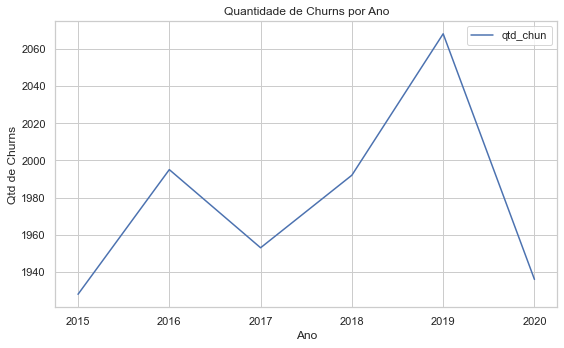

In [233]:
fig, ax = plt.subplots(figsize=(8,5))

df.groupby('ano_primeiro_contrato').agg(qtd_chun=('churn','sum')).plot(kind="line", ax=ax);
ax.set_title("Quantidade de Churns por Ano")
ax.set_ylabel("Qtd de Churns")
ax.set_xlabel("Ano")

plt.tight_layout()

### **Análise:**

Nesta primeira etapa, é possível identificar que:
- Em 2017, o número de churn diminuiu em relação aos demais anos;
- Em 2018 e 2019 temos uma curva ascendente, o que reforça a hipótese H0.
- Em 2020 não podemos considerar os valores uma vez que não temos dados de anos posteriores.

## Identificando a segunda parte de "Churn".

Nesta etapa, foi considerado os clientes ativos e que seu último contrato foi realizado um ano após seu primeiro contrato.

In [234]:
where = (~df.churn)
df.loc[where,'churn'] = df[where].apply(lambda x: True if (x.ano_primeiro_contrato+1)==x.ano_ultimo_contrato else False, axis=1)

In [235]:
df.groupby('ano_primeiro_contrato').agg(clientes=('cd_cliente','nunique'),
                                        qtd_churn=('churn','sum')).reset_index()

,ano_primeiro_contrato,clientes,qtd_churn
0,2015,26892,2826
1,2016,6852,2922
2,2017,4092,3019
3,2018,2935,3158
4,2019,2310,3109
5,2020,1761,1936


In [236]:
churn = df.groupby('ano_primeiro_contrato').agg(clientes=('cd_cliente','nunique'),
                                        churn=('churn','sum')).reset_index()

churn['Percentual_churn'] = churn['churn']/churn['churn'].sum()*100

In [237]:
churn

,ano_primeiro_contrato,clientes,churn,Percentual_churn
0,2015,26892,2826,16.652917
1,2016,6852,2922,17.218621
2,2017,4092,3019,17.790218
3,2018,2935,3158,18.609311
4,2019,2310,3109,18.320566
5,2020,1761,1936,11.408368


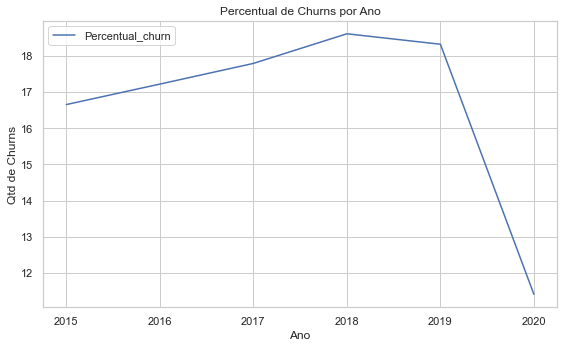

In [238]:
churn[['ano_primeiro_contrato','Percentual_churn']].plot(x='ano_primeiro_contrato', y='Percentual_churn', kind="line", ax=ax);

fig, ax = plt.subplots(figsize=(8,5))

churn[['ano_primeiro_contrato','Percentual_churn']].plot(x='ano_primeiro_contrato', y='Percentual_churn', kind="line", ax=ax);
ax.set_title("Percentual de Churns por Ano")
ax.set_ylabel("Qtd de Churns")
ax.set_xlabel("Ano")

plt.tight_layout()

### **Análise:**

Analisando o gráfico acima, é possível comprovar a Hipótese "H0", uma vez que nota-se a curva ascendente entre os anos de 2015 a 2018, ou seja, o churn de novos clientes é maior do que o churn de clientes ativos.

Em 2019, percebe-se uma leve redução da quantidade de churns, o que não invalida a hipótese "H0" pois, não temos dados referentes ao ano de 2021. Os valores de churn por dois anos de uso não foram considerados neste ano.

Em 2020 não podemos considerar os valores uma vez que não temos dados de anos posteriores.

### **Análise das outras variáveis x dados de "Churn".**

Nas estapas abaixo, analisei a relação dos dados de churn com as outras variáveis do dataset com o objetivo e verificar alguma outra informação relevante ao problema proposto.

### Tipo de Transporte Locado

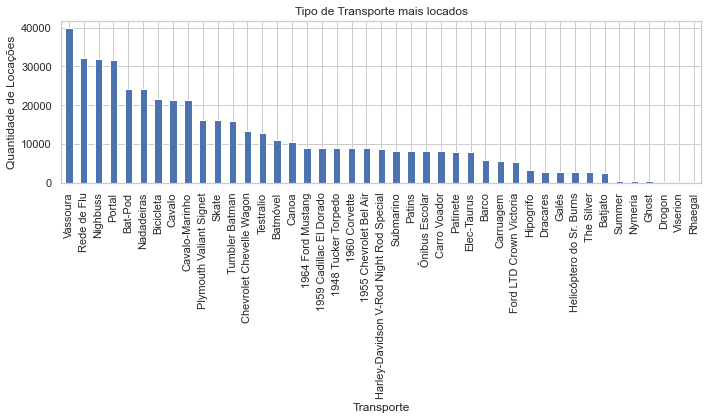

In [239]:
fig, ax = plt.subplots(figsize=(10,6))

df.transporte_locado.value_counts().plot(kind='bar', ax=ax)

ax.set_title("Frequencia de Locações por Tipo de transporte")
ax.set_xlabel("Transporte")
ax.set_ylabel("Quantidade de Locações")

plt.tight_layout()

In [240]:
transporte_locado_df = df.pivot_table(index='transporte_locado', 
                                      columns='churn', 
                                      aggfunc='count', 
                                      values='cd_contrato', margins=True).reset_index()

transporte_locado_df.drop(transporte_locado_df[transporte_locado_df.transporte_locado=='All'].index, axis=0, inplace=True)

In [241]:
transporte_locado_df.head()

churn,transporte_locado,False,True,All
0,1948 Tucker Torpedo,8598,290,8888
1,1955 Chevrolet Bel Air,8553,316,8869
2,1959 Cadillac El Dorado,8682,290,8972
3,1960 Corvette,8561,325,8886
4,1964 Ford Mustang,8707,308,9015


In [242]:
transporte_locado_df.columns = ['transporte_locado','churn_false','churn_true','Total']
transporte_locado_df.sort_values(by='Total', ascending=False, inplace=True)

In [243]:
transporte_locado_df['Perc_churn'] = transporte_locado_df.apply(lambda x: x.churn_true/x.Total*100, axis=1)

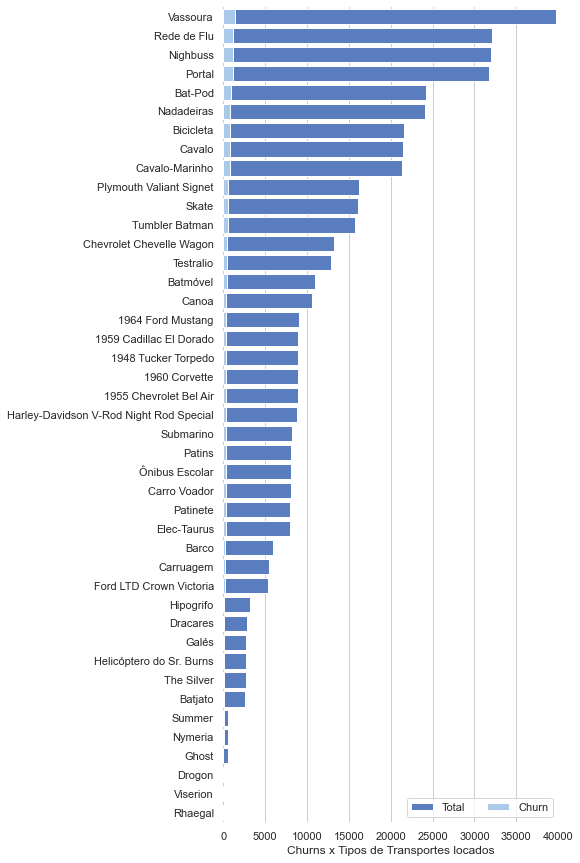

In [244]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("muted")
sns.barplot(x="Total", y="transporte_locado", data=transporte_locado_df,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("pastel")
sns.barplot(x="churn_true", y="transporte_locado", data=transporte_locado_df,
            label="Churn", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 40000), ylabel="",
       xlabel="Relação de Churns x Tipos de Transportes locados")
sns.despine(left=True, bottom=True)

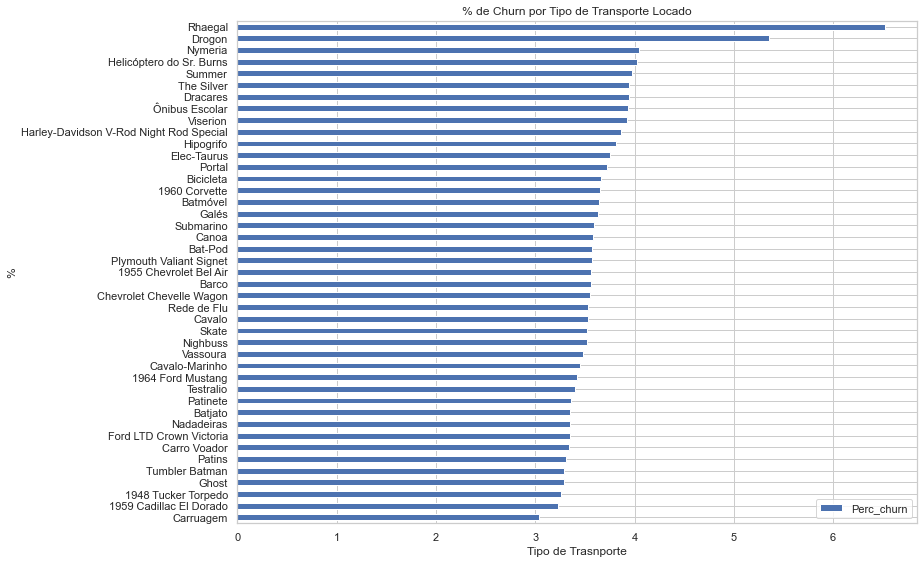

In [245]:
transporte_locado_df.sort_values(by='Perc_churn', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(13,8))

transporte_locado_df.plot(x="transporte_locado", y="Perc_churn", kind="barh", ax=ax)

ax.set_title("% de Churn por Tipo de Transporte Locado")
ax.set_xlabel("Tipo de Trasnporte")
ax.set_ylabel("%")

plt.tight_layout()

### **Análise:**

Analisando os gráficos acima não foi possível identificar uma relação entre a quantidade de churns e o tipo de transporte, uma vez que os churns com maior representatividade ocorreram em transportes com menor quantidade de locações.

## Analisando os Churns por Cidade

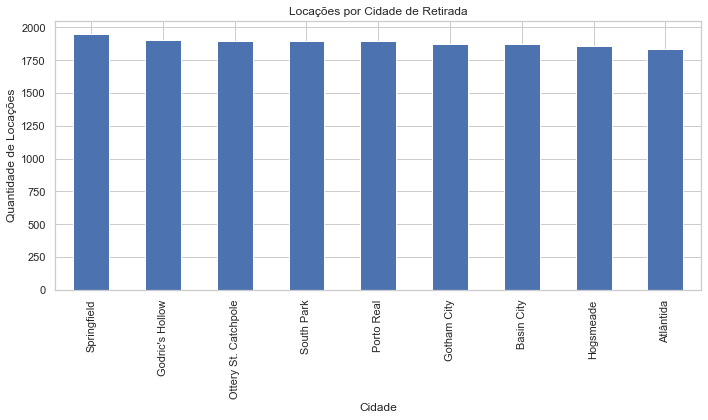

In [246]:
fig, ax = plt.subplots(figsize=(10,6))

where = df.churn==True
df[where].cidade_retirada.value_counts().plot(kind='bar', ax=ax)

ax.set_title("Locações por Cidade de Retirada")
ax.set_xlabel("Cidade")
ax.set_ylabel("Quantidade de Locações")

plt.tight_layout()

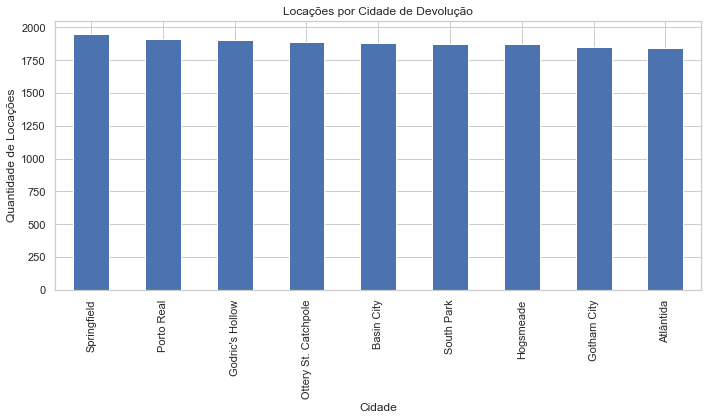

In [247]:
fig, ax = plt.subplots(figsize=(10,6))

where = df.churn==True
df[where].cidade_devolucao.value_counts().plot(kind='bar', ax=ax)

ax.set_title("Locações por Cidade de Devolução")
ax.set_xlabel("Cidade")
ax.set_ylabel("Quantidade de Locações")

plt.tight_layout()

### Analisando os dados de Churn considerando se a devolução do transporte foi realizado na mesma cidade ou em outra cidade.

In [248]:
df['dev_same_city'] = df.apply(lambda x: True if x.cidade_retirada==x.cidade_devolucao else False, axis=True)

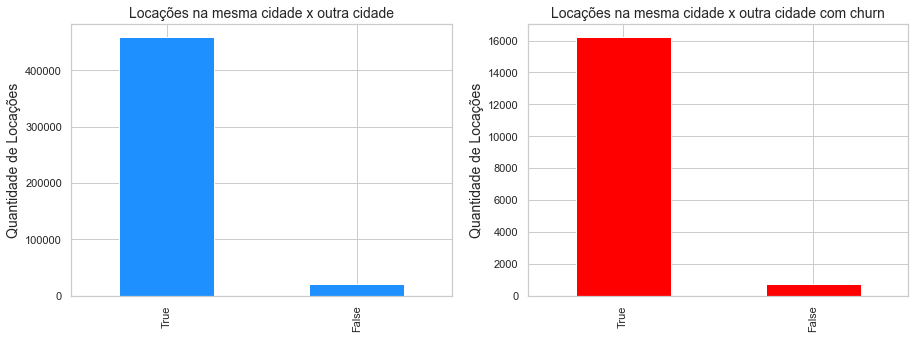

In [249]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

df['dev_same_city'].value_counts().plot(kind='bar', ax=ax[0], color='dodgerblue');
ax[0].set_title('Locações na mesma cidade x outra cidade', fontsize=14)
ax[0].set_ylabel(ylabel='Quantidade de Locações', fontsize=14)

where = df.churn==True
df[where]['dev_same_city'].value_counts().plot(kind='bar', ax=ax[1], color='red');
ax[1].set_title('Locações de clientes(Churn) na mesma cidade x outra cidade com churn', fontsize=14)
ax[1].set_ylabel(ylabel='Quantidade de Locações', fontsize=14)

plt.show()

### Analisando os Churns por quantidade de Diárias e quantidade de horas extra.

In [222]:
df[['qtd_diarias','qtd_hora_extra']].describe()

,qtd_diarias,qtd_hora_extra
count,480863.000000,480863.000000
mean,2.466301,0.110892
std,1.892560,0.350490
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,0.000000
max,26.000000,6.000000


In [223]:
where = df.churn==True
df[where][['qtd_diarias','qtd_hora_extra']].describe()

,qtd_diarias,qtd_hora_extra
count,16970.000000,16970.000000
mean,2.515027,0.109075
std,1.933521,0.342202
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,0.000000
max,19.000000,4.000000


# Conclusão

Após identificar os campos relevantes para a análise do problema, observei que a hipótese H0 pode ser aceita: O churn de novos clientes é maior do que o churn de clientes ativos. 

Não foi possível identificar nesta etapa de análise exploratória, uma relação direta dos churns ocorridos com o comportamento de outros atributos do dataframe, o que inviabiliza obter mais detalhes que explicam esta hipótese.  